# Module 05_02: Classifier: targeting GPU and Patching 

Here you will observe that the accuracy is not materially impacted but the speedups are very large. You will generate results suchs as these in this module

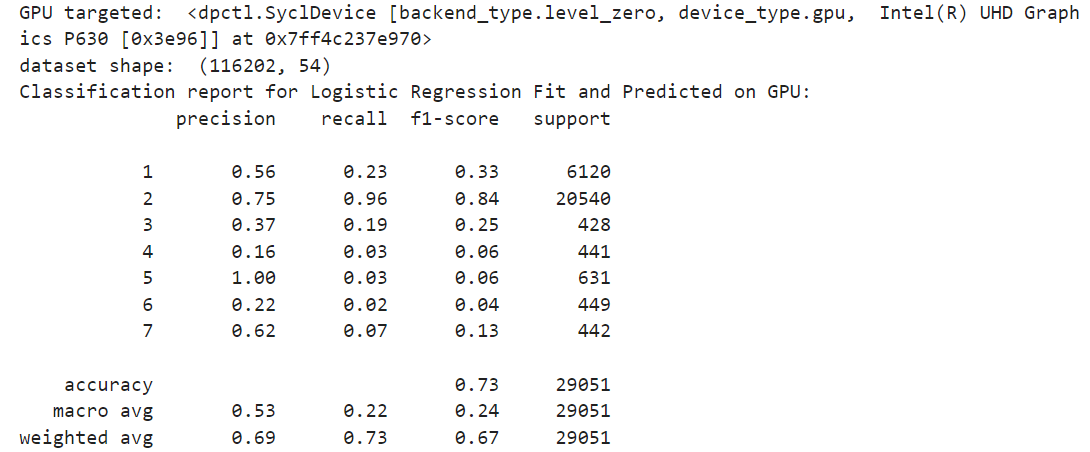



# Learning Objectives:

1) Describe how to apply dpctl compute follows data in conjunction with patching
1) Apply patching to Logistic Regression algorithm on covtype dataset


## Examples dpctl version 12 and later:
```python
x_device = dpctl.tensor.asarray(X, usm_type = 'device', device = "gpu")
y_device = dpctl.tensor.asarray(y, usm_type = 'device', device = "gpu")
```

# *Real World* example Logistic Regression on CovType Dataset

### Compare timings of stock kmeans versus Intel Extension for Scikit-learn Logistic Regression using patch_sklean()

Below we will apply Intel Extension for Scikit learn to a use case on a CPU

Intel® Extension for Scikit-learn contains drop-in replacement functionality for the stock scikit-learn package. You can take advantage of the performance optimizations of Intel Extension for Scikit-learn by adding just two lines of code before the usual scikit-learn imports. Intel® Extension for Scikit-learn patching affects performance of specific Scikit-learn functionality.

### Data: covtype

We will use forest cover type dataset known as covtype and fetch the data from sklearn.datasets


Here we are **predicting forest cover type** from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.


Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

### Overview of procedure
In the below example we will train and predict Logistic Regression algorithm with Intel Extension for Scikit-learn for covtype dataset and calculate the CPU and wall clock time for training and prediction. Then in the next step we will unpatch the Intel extension for Scikit-learn and observe the time taken on the CPU for the same trainng and prediction.

### Fetch the Data

- [Back to Sections](#Back_to_Sections)

# Regarding when/how to cast to and from dpctl.tensors

This information bears repeating: to make sure the concept is clear.

Study the code sectons near the conversion to and from dptcl/Numpy

For all sklearnex alogorithms - it will be necessary to cast the X and/or y data passed as the parameter list to dpctl tensor in order for the GPU to access the data and performan the computation.

Examples:
- **x_device** = dpctl.tensor.from_numpy(**x**, usm_type = 'device', queue=dpctl.SyclQueue(gpu_device))
- **y_device** = dpctl.tensor.from_numpy(**y**, usm_type = 'device', queue=dpctl.SyclQueue(gpu_device))



Pay attention ot **return** types from:
- **fit** - many cases in scikit-learn, fit returns self object - No need to cast
- **fit_predict** - returns **ndarray** requires casting after the call on host (to_numpy)
- **predict** -  returns **ndarray** requires casting after the call on host (to_numpy)
- **fit_transform** - returns returns **ndarray** requires casting after the call on host (to_numpy)
- **tranform** - typically returns **ndarray** requires casting after the call on host (to_numpy)

Scikit-learn routines that potentially return ndarray type objects or which expect ndtype objects passed as a parameter will need to be cast to/from numpy from/to dpctl.tensor

To cast data being fed TO one of these routines:
- use dpctl.tensor.from_numpy() to conver from NumPy to dpctl tensor
- use dpctl.tensor.to_numpy() to convert from dpctl tensor to NumPy

Example: After a call to fit_predict:
- **catch_device** = estimator.fit_predict(**x_device**, **y_device**)
- **predictedHost** = dpctl.tensor.to_numpy(**catch_device**)


In [ ]:
import dpctl
print(dpctl.__version__)

In [ ]:
%%writefile lab/compute_Classification_GPU.py
# Copyright 2022 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import pandas as pd

############################3 import dpctl #################################

import dpctl
print(dpctl.__version__)

############################################################################

#########  apply patch here  prior to import of desired scikit-learn #######
from sklearnex import patch_sklearn
patch_sklearn()
############################################################################


from  sklearn.datasets import fetch_covtype
x, y = fetch_covtype(return_X_y=True)
# Data Set Information:
# Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).
# This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

# for sake of time is 1/4th of the data
subset = x.shape[0]//4
x = x[:subset,:]
y = y[:subset]

# Is this computed on GPU or on Host? Remember compute follows data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=72)

#########  Add code to get GPU context and set flag if GPU is available   #######
#########  Add code to to set CPU context as well so this runs on eiher device   #######
for d in dpctl.get_devices():
    gpu_available = False
    for d in dpctl.get_devices():
        if d.is_gpu:
            gpu_device = dpctl.select_gpu_device()
            gpu_available = True
        else:
            cpu_device = dpctl.select_cpu_device() 
if gpu_available:
    print("GPU targeted: ", gpu_device)
else:
    print("CPU targeted: ", cpu_device)
#########################################################################################

if gpu_available:
    ################## add code to cast from Numpy to dpctl_tensors #########################    # target a remote host GPU when submitted via q.sh or qsub -I
        x_train_device = dpctl.tensor.asarray(x_train, usm_type = 'device', device = "gpu")
        y_train_device = dpctl.tensor.asarray(y_train, usm_type = 'device', device = "gpu")
        x_test_device = dpctl.tensor.asarray(x_test, usm_type = 'device', device = "gpu")
        y_test_device = dpctl.tensor.asarray(y_test, usm_type = 'device', device = "gpu")
    ##########################################################################################
else:
    ################## add code to cast from Numpy to dpctl_tensors for Host CPU ####################    # target a remote host GPU when submitted via q.sh or qsub -I    
    # target a remote host CPU when submitted via q.sh or qsub -I
    x_train_device = dpctl.tensor.asarray(x_train, usm_type = 'device', device = "cpu")
    y_train_device = dpctl.tensor.asarray(y_train, usm_type = 'device', device = "cpu")
    x_test_device = dpctl.tensor.asarray(x_test, usm_type = 'device', device = "cpu")
    y_test_device = dpctl.tensor.asarray(y_test, usm_type = 'device', device = "cpu")
    ##########################################################################################

params = {
    'n_neighbors': 40,  
    'weights': 'distance'
}
print('dataset shape: ', x_train_device.shape)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
#LR = KNeighborsClassifier(**params).fit(x_train_device, y_train_device)
#clf = LogisticRegression(random_state=0, solver='lbfgs').fit(x_train_device, y_train_device) # or lbfgs

TestingString = "RandomForestClassifier"
clf = RandomForestClassifier(random_state=0).fit(x_train_device, y_train_device) 
predictedGPU = clf.predict(x_test_device) #Predict on GPU
#predictedCPU = clf.predict(x_test) #Predict on CPU
predictedGPUNumpy = dpctl.tensor.to_numpy(predictedGPU)

################## add code to cast returned results to Numpy to dpctl_tensors ################  
# only need to do this for predict. fit_predict, transform, fit_transform IF I need to use results
# target a remote host GPU when submitted via q.sh or qsub -I    
predictedGPUNumpy = dpctl.tensor.to_numpy(predictedGPU)
###############################################################################################

reportGPU = metrics.classification_report(y_test, predictedGPUNumpy)
print(f"Classification report for {TestingString} Fit and Predicted on GPU:\n{reportGPU}\n")

reportCPU = metrics.classification_report(y_test, predictedCPU)
print(f"Classification report for {TestingString}  Fit on GPU and Predicted on CPU:\n{reportCPU}\n")

#### Build and Run

An alternative to the q method below 
- launch a DevCloud Terminal and qsub to a GPU enabled device as follows:
- qsub -I -l  nodes=1:gpu:ppn=2
- then run the bash script as follows:
- . run_LogisticRegression_dpctl.sh

## Demonstration of speedup without significant loss of accuracy

#### For running in this notebook:
Select the cell below and click run ▶ to compile and execute the code:

In [ ]:
! chmod 755 q; chmod 755 run_Classification_dpctl.sh; if [ -x "$(command -v qsub)" ]; then ./q run_Classification_dpctl.sh; else ./run_Classification_dpctl.sh; fi

In order to cancel optimizations, we use unpatch_sklearn and reimport the class KNeighborsClassifier. Observe the classification_report

## Observations:

We observe that with scikit-learn-intelex compute follow data:

- Easily target training or prediction on GPU
- Easily target training on GPU and prediction on CPU

# Summary:

You have:

1) Applied patching to Logistic Regression algorithm
2) Applied method to submitt Logistic Regression fit to Intel GPU (model on GPU)
3) Applied method to submitt Logistic Regression predict to Intel GPU (model on GPU)
4) Applied method to submitt Logistic Regression predict to Intel CPU (model on CPU)
    

# Notices & Disclaimers 

Intel technologies may require enabled hardware, software or service activation.
No product or component can be absolutely secure.

Your costs and results may vary.

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
*Other names and brands may be claimed as the property of others.

In [ ]:
print("All Done")